In [1]:
library(data.table)
library(ggplot2)
library(dplyr)
#library(viridis)
library(qqman)
#library(qvalue)
#library(Bioconducter)
library(topGO)
"%!in%" <- function(x,table) match(x,table, nomatch = 0) == 0
options(repr.plot.width=20, repr.plot.height=15)


Attaching package: ‘dplyr’

The following objects are masked from ‘package:data.table’:

    between, first, last

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


For example usage please run: vignette('qqman')

Citation appreciated but not required:
Turner, (2018). qqman: an R package for visualizing GWAS results using Q-Q and manhattan plots. Journal of Open Source Software, 3(25), 731, https://doi.org/10.21105/joss.00731.

Loading required package: BiocGenerics
Loading required package: parallel

Attaching package: ‘BiocGenerics’

The following objects are masked from ‘package:parallel’:

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB

The following objects are masked from ‘package:dplyr’:

    combine, intersect, setdiff, union

The fo

__make a sites file to filter out linked loci with pcangsd__

In [ ]:
#how do maf and calls across ind look- also make sites files for angsd and filter sites for pcangsd
sites <- fread("/data/katrinac/APPC_sequencing/DNA/trimmed_reads/mapping/genotypes/angsd/appc_angsd_probs.hwe.gz")
#head(sites)
unlinked <- fread("/data/katrinac/APPC_sequencing/DNA/trimmed_reads/mapping/genotypes/angsd/ngsld/appc_unlinked_for_angsd.txt")
setnames(unlinked, 1:2, c("Chromo", "Position"))
unlinked[, filter := 1] #when ngsld has kept the site, mark with 1 so pcangsd knows to keep it
test_filter_sites <- left_join(sites, unlinked) #join with full sites dt and mark linked  sites with 0
#head(test_filter_sites)
#nrow(test_filter_sites)==nrow(sites) #check that this is true
test_filter_sites[is.na(filter), filter := 0]
#write out for pcangsd
#fwrite(test_filter_sites[,.(filter)], "/data/katrinac/APPC_sequencing/DNA/trimmed_reads/mapping/genotypes/angsd/ngsld/filter_linked_sites_pcangsd.txt", col.names = F)

__make positions file for angsd to restrict to unlinked sites__

In [ ]:
nrow(maf[, .N, by="chromo"])
pyam <- unique(maf[chromo %like% "PYAM"], by="chromo")[, chromo] #add the PYAM sites together
names <- maf[chromo %!in% pyam, .N, by="chromo"][, "chromo"] #get a list of chromosome labels
names_with_pyam <- rbind(names, matrix(nrow=1, ncol=1, "PYAM"), use.names=F)
#fwrite(names_with_pyam, "/data/katrinac/APPC_sequencing/DNA/trimmed_reads/mapping/ensembl/genotypes/angsd/ngsld/chromosomes.txt", col.names =F)

__plot the pcangsd results, color by phenotypes in the association__

In [ ]:
pca <- fread("/data/katrinac/APPC_sequencing/DNA/trimmed_reads/mapping/genotypes/angsd/output.pcangsd.cov")
#get eigenvalues
ev <-eigen(pca)
ev_dt <- data.table(ev$vectors[,1:10])
setnames(ev_dt, c("pc1", "pc2", "pc3", "pc4", "pc5", "pc6", "pc7", "pc8", "pc9", "pc10"))
#variance explained?
ev$values/sum(ev$values)

__join together the metadata with other covariates and phenotypes with the pcs- be sure to check that the samples are ordered the same as bamlist__

In [18]:
bamlist <- fread("/data/katrinac/APPC_sequencing/DNA/trimmed_reads/mapping/genotypes/bamlist.list.txt")
meta <- fread("/data/katrinac/APPC_sequencing/DNA/trimmed_reads/mapping/genotypes/angsd/Sample_Meta.txt")[is.na(Group), Group :=-999][Group=="High", Group:=1][Group=="Low", Group:=0][, .(sample=gen_id, ucrit=Ucrit, sl=SL, dam, sire, case=Group, capture=Capture)]
sorted_meta <- left_join(bamlist, meta, by="sample")
#pca_phenos <- cbind(sorted_meta , ev_dt)[, sequencing_lib := ifelse(capture %in% c("Pop01","Pop02","Pop03", "Pop04", "Pop05", "Pop06", "Pop07","Pop08"), 1, 2)]
#write out the pcs to use as covariates
#fwrite(sorted_meta[, "sl"], "/data/katrinac/APPC_sequencing/DNA/trimmed_reads/mapping/ensembl/genotypes/angsd/SL_pheno_test.yquant", col.names = F)

Warning message in `[.data.table`(fread("/data/katrinac/APPC_sequencing/DNA/trimmed_reads/mapping/genotypes/angsd/Sample_Meta.txt")[is.na(Group), :
“Coerced double RHS to character to match the type of the target column (column 10 named 'Group'). If the target column's type character is correct, it's best for efficiency to avoid the coercion and create the RHS as type character. To achieve that consider R's type postfix: typeof(0L) vs typeof(0), and typeof(NA) vs typeof(NA_integer_) vs typeof(NA_real_). You can wrap the RHS with as.character() to avoid this warning, but that will still perform the coercion. If the target column's type is not correct, it's best to revisit where the DT was created and fix the column type there; e.g., by using colClasses= in fread(). Otherwise, you can change the column type now by plonking a new column (of the desired type) over the top of it; e.g. DT[, `Group`:=as.double(`Group`)]. If the RHS of := has nrow(DT) elements then the assignment is called a c

In [19]:
summary(sorted_meta)

    sample              ucrit             sl            dam           
 Length:159         Min.   :0.130   Min.   :3.920   Length:159        
 Class :character   1st Qu.:1.015   1st Qu.:4.160   Class :character  
 Mode  :character   Median :3.780   Median :4.270   Mode  :character  
                    Mean   :4.098   Mean   :4.254                     
                    3rd Qu.:6.775   3rd Qu.:4.350                     
                    Max.   :9.450   Max.   :4.560                     
                                    NA's   :12                        
     sire               case             capture         
 Length:159         Length:159         Length:159        
 Class :character   Class :character   Class :character  
 Mode  :character   Mode  :character   Mode  :character  
                                                         
                                                         
                                                         
                          

In [ ]:
cor.test(pca_phenos$ucrit, pca_phenos$sl)

In [ ]:
ucrit_fam <- ggplot()+
geom_histogram(data=pca_phenos, aes(x=ucrit), color="black", fill="gray")+
 ylab("Frequency") +
    xlab("Ucrit")+
    theme(strip.text.x = element_text(size = 14),
    legend.position = "bottom",
    legend.key=element_blank(),
    panel.grid.major = element_blank(),
    panel.grid.minor = element_blank(), 
    panel.background = element_blank(), #,
    axis.line = element_line(colour = "black"),axis.text.x =  element_text(size=18, color="black"),#15 for publication, 20 for presentation #element_text(size=15, color="black", family="Helvetica"),
    axis.title.y =  element_text(size=18, color="black"),
    axis.title.x =  element_text(size=18, color="black"),#15 for publication, 20 for presentation #element_text(size=15, color="black", family="Helvetica"),
    axis.text.y =  element_text(size=18, color="black"))+
    scale_x_continuous(limits = c(0,9), expand = c(0, 0), breaks=c(seq(0, 9, 1))) +    
    scale_y_continuous(expand = c(0,0), limits = c(0,18)) 

ucrit_fam
ggsave(plot=ucrit_fam, filename = "/data/katrinac/APPC_sequencing/DNA/trimmed_reads/mapping/ensembl/genotypes/angsd/results/ucrit_dist_pres.pdf")

In [ ]:
sl_fam <- ggplot()+
geom_histogram(data=pca_phenos, aes(x=sl), color="black", fill="gray")+
 ylab("Frequency") +
    xlab("Body size (mm)")+
    theme(strip.text.x = element_text(size = 14),
    legend.position = "bottom",
    legend.key=element_blank(),
    panel.grid.major = element_blank(),
    panel.grid.minor = element_blank(), 
    panel.background = element_blank(), #,
    axis.line = element_line(colour = "black"),axis.text.x =  element_text(size=18, color="black"),#15 for publication, 20 for presentation #element_text(size=15, color="black", family="Helvetica"),
    axis.title.y =  element_text(size=18, color="black"),
    axis.title.x =  element_text(size=18, color="black"),#15 for publication, 20 for presentation #element_text(size=15, color="black", family="Helvetica"),
    axis.text.y =  element_text(size=18, color="black"))+
    scale_x_continuous(limits = c(3.9,4.7), expand = c(0, 0), breaks=c(seq(3.9, 4.6, .1))) +    
    scale_y_continuous(expand = c(0,0), limits = c(0,18)) 

sl_fam
ggsave(plot=sl_fam, filename = "/data/katrinac/APPC_sequencing/DNA/trimmed_reads/mapping/ensembl/genotypes/angsd/results/sl_dist_pres.pdf")

In [ ]:
summary(pca_phenos$sl)

In [ ]:
predictors <- as.data.table(summary(glm(data=pca_phenos, ucrit ~ pc1+pc2+pc3))$coeff)
 
predictors$names <- row.names(summary(glm(data=pca_phenos, ucrit ~ pc1+pc2+pc3))$coeff)
setnames(predictors, 4, "pvalue")
predictors[pvalue <0.08][order(pvalue)]

In [ ]:
summary(lm(data=pca_phenos, sl ~pc1+pc2+pc3))

In [ ]:
#what pcs/covariates explain the phenotype?
predictors <- as.data.table(summary(glm(data=pca_phenos, sl ~pc1+pc2+pc3))$coeff)
 
predictors$names <- row.names(summary(glm(data=pca_phenos, sl ~ pc1+pc2+pc3))$coeff)
setnames(predictors, 4, "pvalue")
predictors[pvalue <0.06][order(pvalue)]

In [ ]:
library(broom)

In [ ]:
summary(glm(data=pca_phenos, sl ~pc1+pc2+pc3))
sl_results <- tidy(glm(data=pca_phenos, sl ~pc1+pc2+pc3))
fwrite(sl_results, "/data/katrinac/APPC_sequencing/DNA/trimmed_reads/mapping/ensembl/genotypes/angsd/results/sl_pca_glm.csv" )
ucrit_results <- tidy(glm(data=pca_phenos, ucrit ~pc1+pc2+pc3))
fwrite(ucrit_results, "/data/katrinac/APPC_sequencing/DNA/trimmed_reads/mapping/ensembl/genotypes/angsd/results/ucrit_pca_glm.csv" )


In [ ]:
#fwrite(pca_phenos[,.(pc1, pc2, pc3)],"/data/katrinac/APPC_sequencing/DNA/trimmed_reads/mapping/genotypes/angsd/pc1-3_unlinked.cov", col.names = FALSE )

In [ ]:
str(pca_phenos)

In [ ]:
pca_plot <- ggplot(data=pca_phenos, aes(x=pc1, y=pc2, color=sire))+
    geom_point()+
    xlab("PC1, 22.19% variance explained")+
    ylab("PC2, 0.05% variance explained")
pca_plot

In [ ]:
pca_plot <- ggplot(data=pca_phenos, aes(x=pc1, y=pc2, color=sire))+
    geom_point()+
    xlab("PC1, 22.19% variance explained")+
    ylab("PC2, 0.05% variance explained") +
    theme(strip.text.x = element_text(size = 14),
    axis.text.x =  element_text(size=14, color="black"),#15 for publication, 20 for presentation #element_text(size=15, color="black", family="Helvetica"),
    axis.title.y =  element_text(size=18, color="black"),
    axis.title.x =  element_text(size=18, color="black"),#15 for publication, 20 for presentation #element_text(size=15, color="black", family="Helvetica"),
    axis.text.y =  element_text(size=18, color="black"))
pca_plot

In [ ]:
ggsave(plot=pca_plot, filename = "/data/katrinac/APPC_sequencing/DNA/trimmed_reads/mapping/ensembl/genotypes/angsd/results/pca_sire_color_pres.pdf")

In [ ]:
#ggplot()+
#    geom_point(data=pca_phenos[], aes(x=pc1, y=pc2, col=sl)) +
#    scale_color_viridis(color.palette=magma)

In [ ]:
#ggplot()+
#    geom_point(data=pca_phenos, aes(x=pc1, y=pc2, col=ucrit)) +
#    scale_color_viridis(option="magma")

In [ ]:
#ggplot()+
#    geom_point(data=pca_phenos, aes(x=pc1, y=pc2, col=sequencing_lib)) +
#    scale_color_viridis(option="magma")

In [ ]:
ggplot(data=pca_phenos, aes(x=pc1, y=pc2, col=dam, label=sample))+
    geom_point() #+
    #geom_text(nudge_x = 0.02)

In [5]:
tempdir()

[1] "/tmp/Rtmp9bJiGF"

### evaluate model and plot GWAS results for each phenotype

In [18]:
lrt_ucrit <- fread(file="/data/katrinac/APPC_sequencing/DNA/trimmed_reads/mapping/ensembl/genotypes/angsd/ucrit_assoc2_maf0.05_noMaxdepth_unlinkedPC1cov_minQ30_minCount16.lrt0")
lrt_ucrit[, locus := paste(Chromosome, Position, sep=":")]
#setnames(lrt_ucrit, "LRTscore", "LRT")

#filter out loci in hwe and NAN
lrt_filt_ucrit <- lrt_ucrit[LRT>0][Chromosome %in% as.character(seq(1,24,1))]#[, Chromosome := paste0("chr", Chromosome, sep="")] 
#format for manhattan plot
#get pvalues
lrt_filt_ucrit$pvalue<-pchisq(lrt_filt_ucrit$LRT, df=1, lower=F)
#lrt_filt_ucrit[, Chromosome := gsub("CM","", Chromosome, fixed = T)][, Chromosome := gsub("PYAM","", Chromosome, fixed = T)]#[, Chromosome := gsub(".","", Chromosome, fixed = T)]
lrt_filt_ucrit[, Chromosome_man := as.numeric(Chromosome)]
lrt_filt_ucrit$SNP<-paste("r",1:length(lrt_filt_ucrit$Chromosome), sep="")


In [13]:
nrow(lrt_filt_ucrit)
#summary(lrt_filt_sl)

[1] 132106

In [19]:
lrt_sl <- fread("/data/katrinac/APPC_sequencing/DNA/trimmed_reads/mapping/ensembl/genotypes/angsd/sl_assoc2_maf0.05_noMaxdepth_unlinkedPC1cov_minQ30_minCount16.lrt0")
lrt_sl[, locus := paste(Chromosome, Position, sep=":")]
#for hybrid assoc 5
#setnames(lrt_sl, "LRTscore", "LRT")
#filter out loci in hwe and NAN
lrt_filt_sl <- lrt_sl[LRT>0][Chromosome %in% as.character(seq(1,24,1))]#[, Chromosome := paste0("chr", Chromosome, sep="")] 
#lrt_filt <- lrt[LRT>0]
#format for manhattan plot
#get pvalues
lrt_filt_sl$pvalue<-pchisq(lrt_filt_sl$LRT, df=1, lower=F)
#lrt_filt_sl[, Chromosome := gsub(".","", Chromosome, fixed = T)][, Chromosome := gsub("CM","", Chromosome, fixed = T)][, Chromosome := gsub("PYAM","", Chromosome, fixed = T)]
lrt_filt_sl[, Chromosome_man := as.numeric(Chromosome)]
lrt_filt_sl$SNP<-paste("r",1:length(lrt_filt_sl$Chromosome), sep="")
nrow(lrt_filt_sl)
head(lrt_filt_sl)

[1] 105379

Chromosome,Position,Major,Minor,Frequency,N,LRT,high_WT/HE/HO,locus,pvalue,Chromosome_man,SNP
1,10004,A,G,0.109734,147,0.096277,42/14/0,1:10004,0.7563440,1,r1
1,32316,T,G,0.339790,147,0.843309,11/20/0,1:32316,0.3584521,1,r2
1,32326,T,C,0.206107,147,0.842760,20/11/0,1:32326,0.3586086,1,r3
1,32350,A,G,0.299364,147,0.125366,10/10/1,1:32350,0.7232860,1,r4
1,32897,C,T,0.198828,147,1.057497,13/11/0,1:32897,0.3037868,1,r5
1,33219,A,G,0.245286,147,0.272930,13/12/0,1:33219,0.6013730,1,r6


In [ ]:
#png("/data/katrinac/APPC_sequencing/DNA/trimmed_reads/mapping/ensembl/genotypes/angsd/results/pval_qq_ucrit_uniform.png")
qqman::qq(lrt_filt_ucrit$pvalue)
#dev.off()

#png("/data/katrinac/APPC_sequencing/DNA/trimmed_reads/mapping/ensembl/genotypes/angsd/results/pval_qq_sl_uniform.png")
qqman::qq(lrt_filt_sl$pvalue)
#dev.off()


In [ ]:
#compare plots and inflation 
#pdf("/data/katrinac/APPC_sequencing/DNA/trimmed_reads/mapping/ensembl/genotypes/angsd/results/lrt_qq_ucrit.pdf")
qqplot(lrt_filt_ucrit$exp_lrt, lrt_filt_ucrit$LRT, xlab = "Expected LRT", ylab="Observed LRT")
abline(0, 1, col = "red")
#dev.off()
#median(lrt_filt_ucrit$LRT) / median(lrt_filt_ucrit$exp_lrt) #GC lambda = ratio at medians
#summary(lrt_filt_ucrit$LRT)

#pdf("/data/katrinac/APPC_sequencing/DNA/trimmed_reads/mapping/ensembl/genotypes/angsd/results/lrt_qq_sl.pdf")
qqplot(lrt_filt_sl$exp_lrt, lrt_filt_sl$LRT, xlab = "Expected LRT", ylab="Observed LRT")
abline(0, 1, col = "red")
#dev.off()
#median(lrt_filt_sl$LRT) / median(lrt_filt_sl$exp_lrt) #GC lambda = ratio at medians
#summary(lrt_filt_sl$LRT)


In [ ]:
#are the pvalues correlated for phenotypes?
for_corr_plot <- (left_join(lrt_filt_sl, lrt_filt_ucrit, by="locus"))[, .(sl_neg_log_pvalue=-log10(pvalue.x), ucrit_neg_log_pvalue=-log10(pvalue.y), locus)]


In [ ]:
cor.test(for_corr_plot$sl_neg_log_pvalue, for_corr_plot$ucrit_neg_log_pvalue)
#png("/data/katrinac/APPC_sequencing/DNA/trimmed_reads/mapping/ensembl/genotypes/angsd/results/pval_correalation.png")
plot(for_corr_plot$sl_neg_log_pvalue, for_corr_plot$ucrit_neg_log_pvalue, xlab = "SL -log10(pvalue)", ylab = "Ucrit -log10(pvalue)")
#dev.off()

__BH correction__

__Stricter pvalue cutoff from Malin__

In [2]:
ucrit_files <- list.files(path = "/data/katrinac/APPC_sequencing/DNA/trimmed_reads/mapping/ensembl/genotypes/angsd/permute/increase_n/", pattern = glob2rx("^ucrit*.lrt0"))

null_int <- as.data.frame(matrix(nrow=0, ncol=10))
setDT(null_int)
setnames(null_int, c("Chromosome", "Position", "Major", "Minor", "Frequency", "N", "LRT","high_WT/HE/HO", "pvalue", "iteration"))

for(i in 1:length(ucrit_files)){
    null <- fread(paste("/data/katrinac/APPC_sequencing/DNA/trimmed_reads/mapping/ensembl/genotypes/angsd/permute/increase_n/", ucrit_files[i], sep=""))[LRT >0 & Chromosome <=24][, pvalue:=pchisq(LRT, df=1, lower=F)][, iteration := i]
    null_int <- rbind(null_int, null)
}
lrt_null_ucrit <- null_int
#ucrit_null_chrom <- null_int
#ucrit_null_chrom_lowest <- ucrit_null_chrom[, .(lower.25=quantile(min_pvalue, .025)[[1]]), by=Chromosome][,Chromosome:=paste0("chr", Chromosome, sep="")]
#ucrit_null.25 <- left_join(ucrit_null_chrom_lowest, lrt_filt_ucrit[Chromosome %like%"chr"])[pvalue <=lower.25]
#ucrit_null.25

In [14]:
ucrit_files <- list.files(path = "/data/katrinac/APPC_sequencing/DNA/trimmed_reads/mapping/ensembl/genotypes/angsd/permute/increase_n/", pattern = glob2rx("^ucrit*.lrt0"))
length(ucrit_files)

[1] 500

In [3]:
sl_files <- list.files(path = "/data/katrinac/APPC_sequencing/DNA/trimmed_reads/mapping/ensembl/genotypes/angsd/permute/increase_n/", pattern = glob2rx("^sl*.lrt0"))

null_int <- as.data.frame(matrix(nrow=0, ncol=10))
setDT(null_int)
setnames(null_int, c("Chromosome", "Position", "Major", "Minor", "Frequency", "N", "LRT","high_WT/HE/HO", "pvalue", "iteration"))
for(i in 1:length(sl_files)){
    null <- fread(paste("/data/katrinac/APPC_sequencing/DNA/trimmed_reads/mapping/ensembl/genotypes/angsd/permute/increase_n/", sl_files[i], sep=""))[LRT >0 & Chromosome <=24][, pvalue:=pchisq(LRT, df=1, lower.tail = F)][, iteration := i]
    null_int <- rbind(null_int, null)
}
lrt_null_sl <- null_int
#sl_null_chrom_lowest <- sl_null_chrom[, .(lower.25=quantile(min_pvalue, .025)[[1]]), by=Chromosome][,Chromosome:=paste0("chr", Chromosome, sep="")]
#sl_null.25 <- left_join(sl_null_chrom_lowest, lrt_filt_sl[Chromosome %like%"chr"])[pvalue <=lower.25]
#sl_null.25

In [4]:
head(lrt_null_sl)

Chromosome,Position,Major,Minor,Frequency,N,LRT,high_WT/HE/HO,pvalue,iteration
1,10004,A,G,0.109734,147,0.253607,43/15/0,0.6145467,1
1,32316,T,G,0.339790,147,0.108990,11/24/0,0.7412969,1
1,32326,T,C,0.206107,147,0.567159,20/14/0,0.4513901,1
1,32350,A,G,0.299364,147,0.340653,12/10/2,0.5594525,1
1,32897,C,T,0.198828,147,0.098019,14/11/0,0.7542200,1
1,33219,A,G,0.245286,147,0.010661,14/12/0,0.9177629,1


In [5]:
#make a summary table with all relevant info so I don't have to read in all of the raw results from each simulation
lrt_sl_null_summary <- lrt_null_sl[, .(min_pvalue=min(pvalue), min_lrt=min(LRT), pval_0.01=quantile(pvalue, .01)[[1]], pval_0.025=quantile(pvalue, .025)[[1]], pval_0.05=quantile(pvalue, .05)[[1]]), by=c("Chromosome", "Position")]
lrt_ucrit_null_summary <- lrt_null_ucrit[, .(min_pvalue=min(pvalue), min_lrt=min(LRT), pval_0.01=quantile(pvalue, .01)[[1]], pval_0.025=quantile(pvalue, .025)[[1]], pval_0.05=quantile(pvalue, .05)[[1]]), by=c("Chromosome", "Position")]

#and then a table for genome wide values
lrt_sl_null_summary_gw <- lrt_null_sl[, .(min_pvalue=min(pvalue), min_lrt=min(LRT), pval_0.01=quantile(pvalue, .01)[[1]], pval_0.025=quantile(pvalue, .025)[[1]], pval_0.05=quantile(pvalue, .05)[[1]]), by=iteration] 
lrt_ucrit_null_summary_gw <- lrt_null_ucrit[, .(min_pvalue=min(pvalue), min_lrt=min(LRT), pval_0.01=quantile(pvalue, .01)[[1]], pval_0.025=quantile(pvalue, .025)[[1]], pval_0.05=quantile(pvalue, .05)[[1]]), by=iteration] 



In [13]:
#write out these summaries for future use
fwrite(lrt_ucrit_null_summary, file="/data/katrinac/APPC_sequencing/DNA/trimmed_reads/mapping/ensembl/genotypes/angsd/results/ucrit_null_SNP_summary_500perm.csv")
fwrite(lrt_sl_null_summary, file="/data/katrinac/APPC_sequencing/DNA/trimmed_reads/mapping/ensembl/genotypes/angsd/results/sl_null_SNP_summary_500perm.csv")

fwrite(lrt_ucrit_null_summary_gw, file="/data/katrinac/APPC_sequencing/DNA/trimmed_reads/mapping/ensembl/genotypes/angsd/results/ucrit_null_SNP_summary_500perm_gw.csv")
fwrite(lrt_sl_null_summary_gw, file="/data/katrinac/APPC_sequencing/DNA/trimmed_reads/mapping/ensembl/genotypes/angsd/results/sl_null_SNP_summary_500perm_gw.csv")

In [4]:
#read back in the results for plotting
ucrit_gw_null <- fread(file="/data/katrinac/APPC_sequencing/DNA/trimmed_reads/mapping/ensembl/genotypes/angsd/results/ucrit_null_SNP_summary_500perm_gw.csv")
sl_gw_null <- fread(file="/data/katrinac/APPC_sequencing/DNA/trimmed_reads/mapping/ensembl/genotypes/angsd/results/sl_null_SNP_summary_500perm_gw.csv")

In [40]:
ucrit_snp_null <- fread(file="/data/katrinac/APPC_sequencing/DNA/trimmed_reads/mapping/ensembl/genotypes/angsd/results/ucrit_null_SNP_summary_500perm.csv")[, Chromosome:=as.numeric(Chromosome)]
sl_snp_null <- fread(file="/data/katrinac/APPC_sequencing/DNA/trimmed_reads/mapping/ensembl/genotypes/angsd/results/sl_null_SNP_summary_500perm.csv")[, Chromosome:=as.numeric(Chromosome)]

In [41]:
head(ucrit_snp_null)

Chromosome,Position,min_pvalue,min_lrt,pval_0.01,pval_0.025,pval_0.05
1,10004,0.005052284,3.8e-05,0.010441082,0.02428581,0.05281940
1,32316,0.001111583,9.0e-06,0.005078951,0.02536276,0.05324121
1,32326,0.002335550,1.0e-06,0.009626446,0.02060651,0.05394256
1,32350,0.001492978,1.0e-06,0.015603733,0.02515098,0.05103984
1,32897,0.004311850,3.0e-06,0.019411956,0.03399851,0.04809844
1,33219,0.002035361,1.2e-05,0.009326496,0.02574312,0.04780894


In [8]:
ucrit_gw_cutoff <- quantile(ucrit_gw_null$min_pvalue, 0.05)[[1]]
ucrit_gw_cutoff
sl_gw_cutoff <-quantile(sl_gw_null$min_pvalue, 0.05)[[1]]
sl_gw_cutoff

[1] 3.383631e-06

[1] 3.541982e-06

In [20]:
str(lrt_filt_sl)

Classes ‘data.table’ and 'data.frame':	105379 obs. of  12 variables:
 $ Chromosome    : chr  "1" "1" "1" "1" ...
 $ Position      : int  10004 32316 32326 32350 32897 33219 33269 33281 34051 34187 ...
 $ Major         : chr  "A" "T" "T" "A" ...
 $ Minor         : chr  "G" "G" "C" "G" ...
 $ Frequency     : num  0.11 0.34 0.206 0.299 0.199 ...
 $ N             : int  147 147 147 147 147 147 147 147 147 147 ...
 $ LRT           : num  0.0963 0.8433 0.8428 0.1254 1.0575 ...
 $ high_WT/HE/HO : chr  "42/14/0" "11/20/0" "20/11/0" "10/10/1" ...
 $ locus         : chr  "1:10004" "1:32316" "1:32326" "1:32350" ...
 $ pvalue        : num  0.756 0.358 0.359 0.723 0.304 ...
 $ Chromosome_man: num  1 1 1 1 1 1 1 1 1 1 ...
 $ SNP           : chr  "r1" "r2" "r3" "r4" ...
 - attr(*, ".internal.selfref")=<externalptr> 


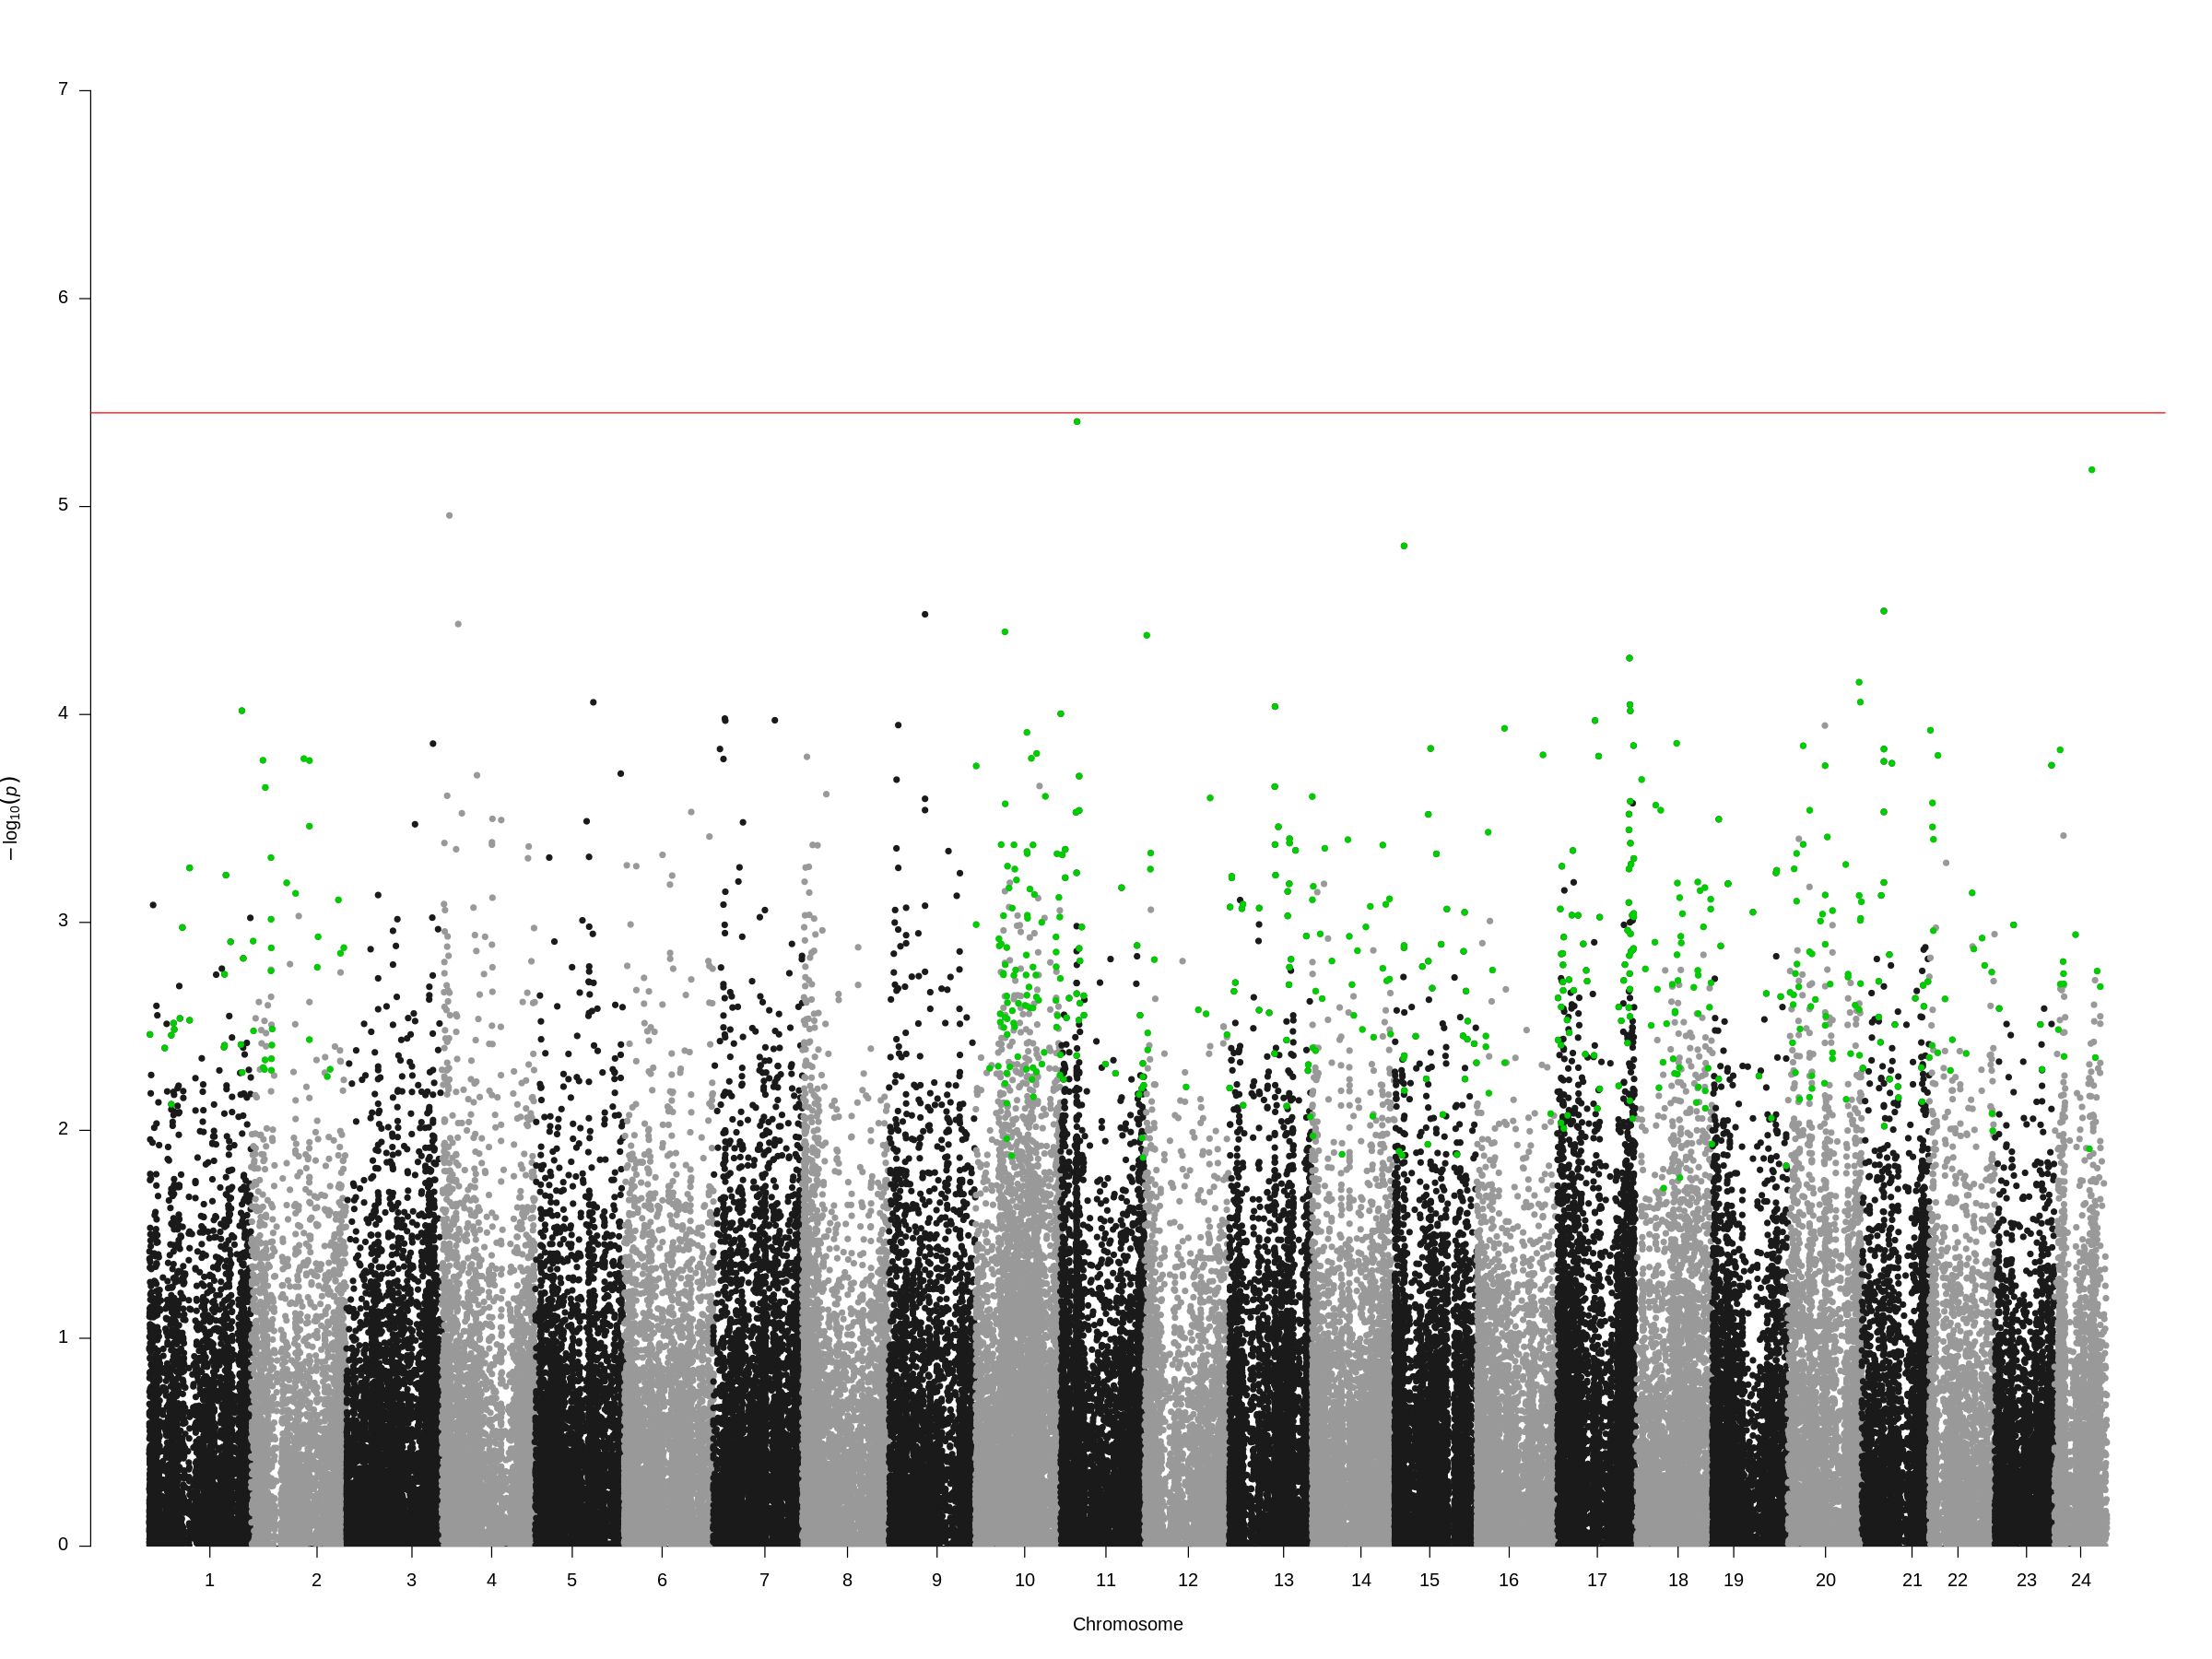

In [48]:
#gw_sl <- quantile(sl_null_lowest$null_min_pvalue, .025)[[1]]
#gw_sl_null <- dchisq(min(sl_null_top$LRT), df=1)
#png("/data/katrinac/APPC_sequencing/DNA/trimmed_reads/mapping/ensembl/genotypes/angsd/results/sl_manhattan_chrom_null_sig_minq_0.05.png")
qqman::manhattan(lrt_filt_sl, chr="Chromosome_man", bp="Position", p="pvalue", genomewideline = -log10(sl_gw_cutoff), ylim = c(0, 7), suggestiveline = F)#, highlight =lrt_filt_sl[locus %in% sl_perm_pvalues_int[pvalue < min_pvalue, locus], SNP])
#dev.off()
#gw_sl

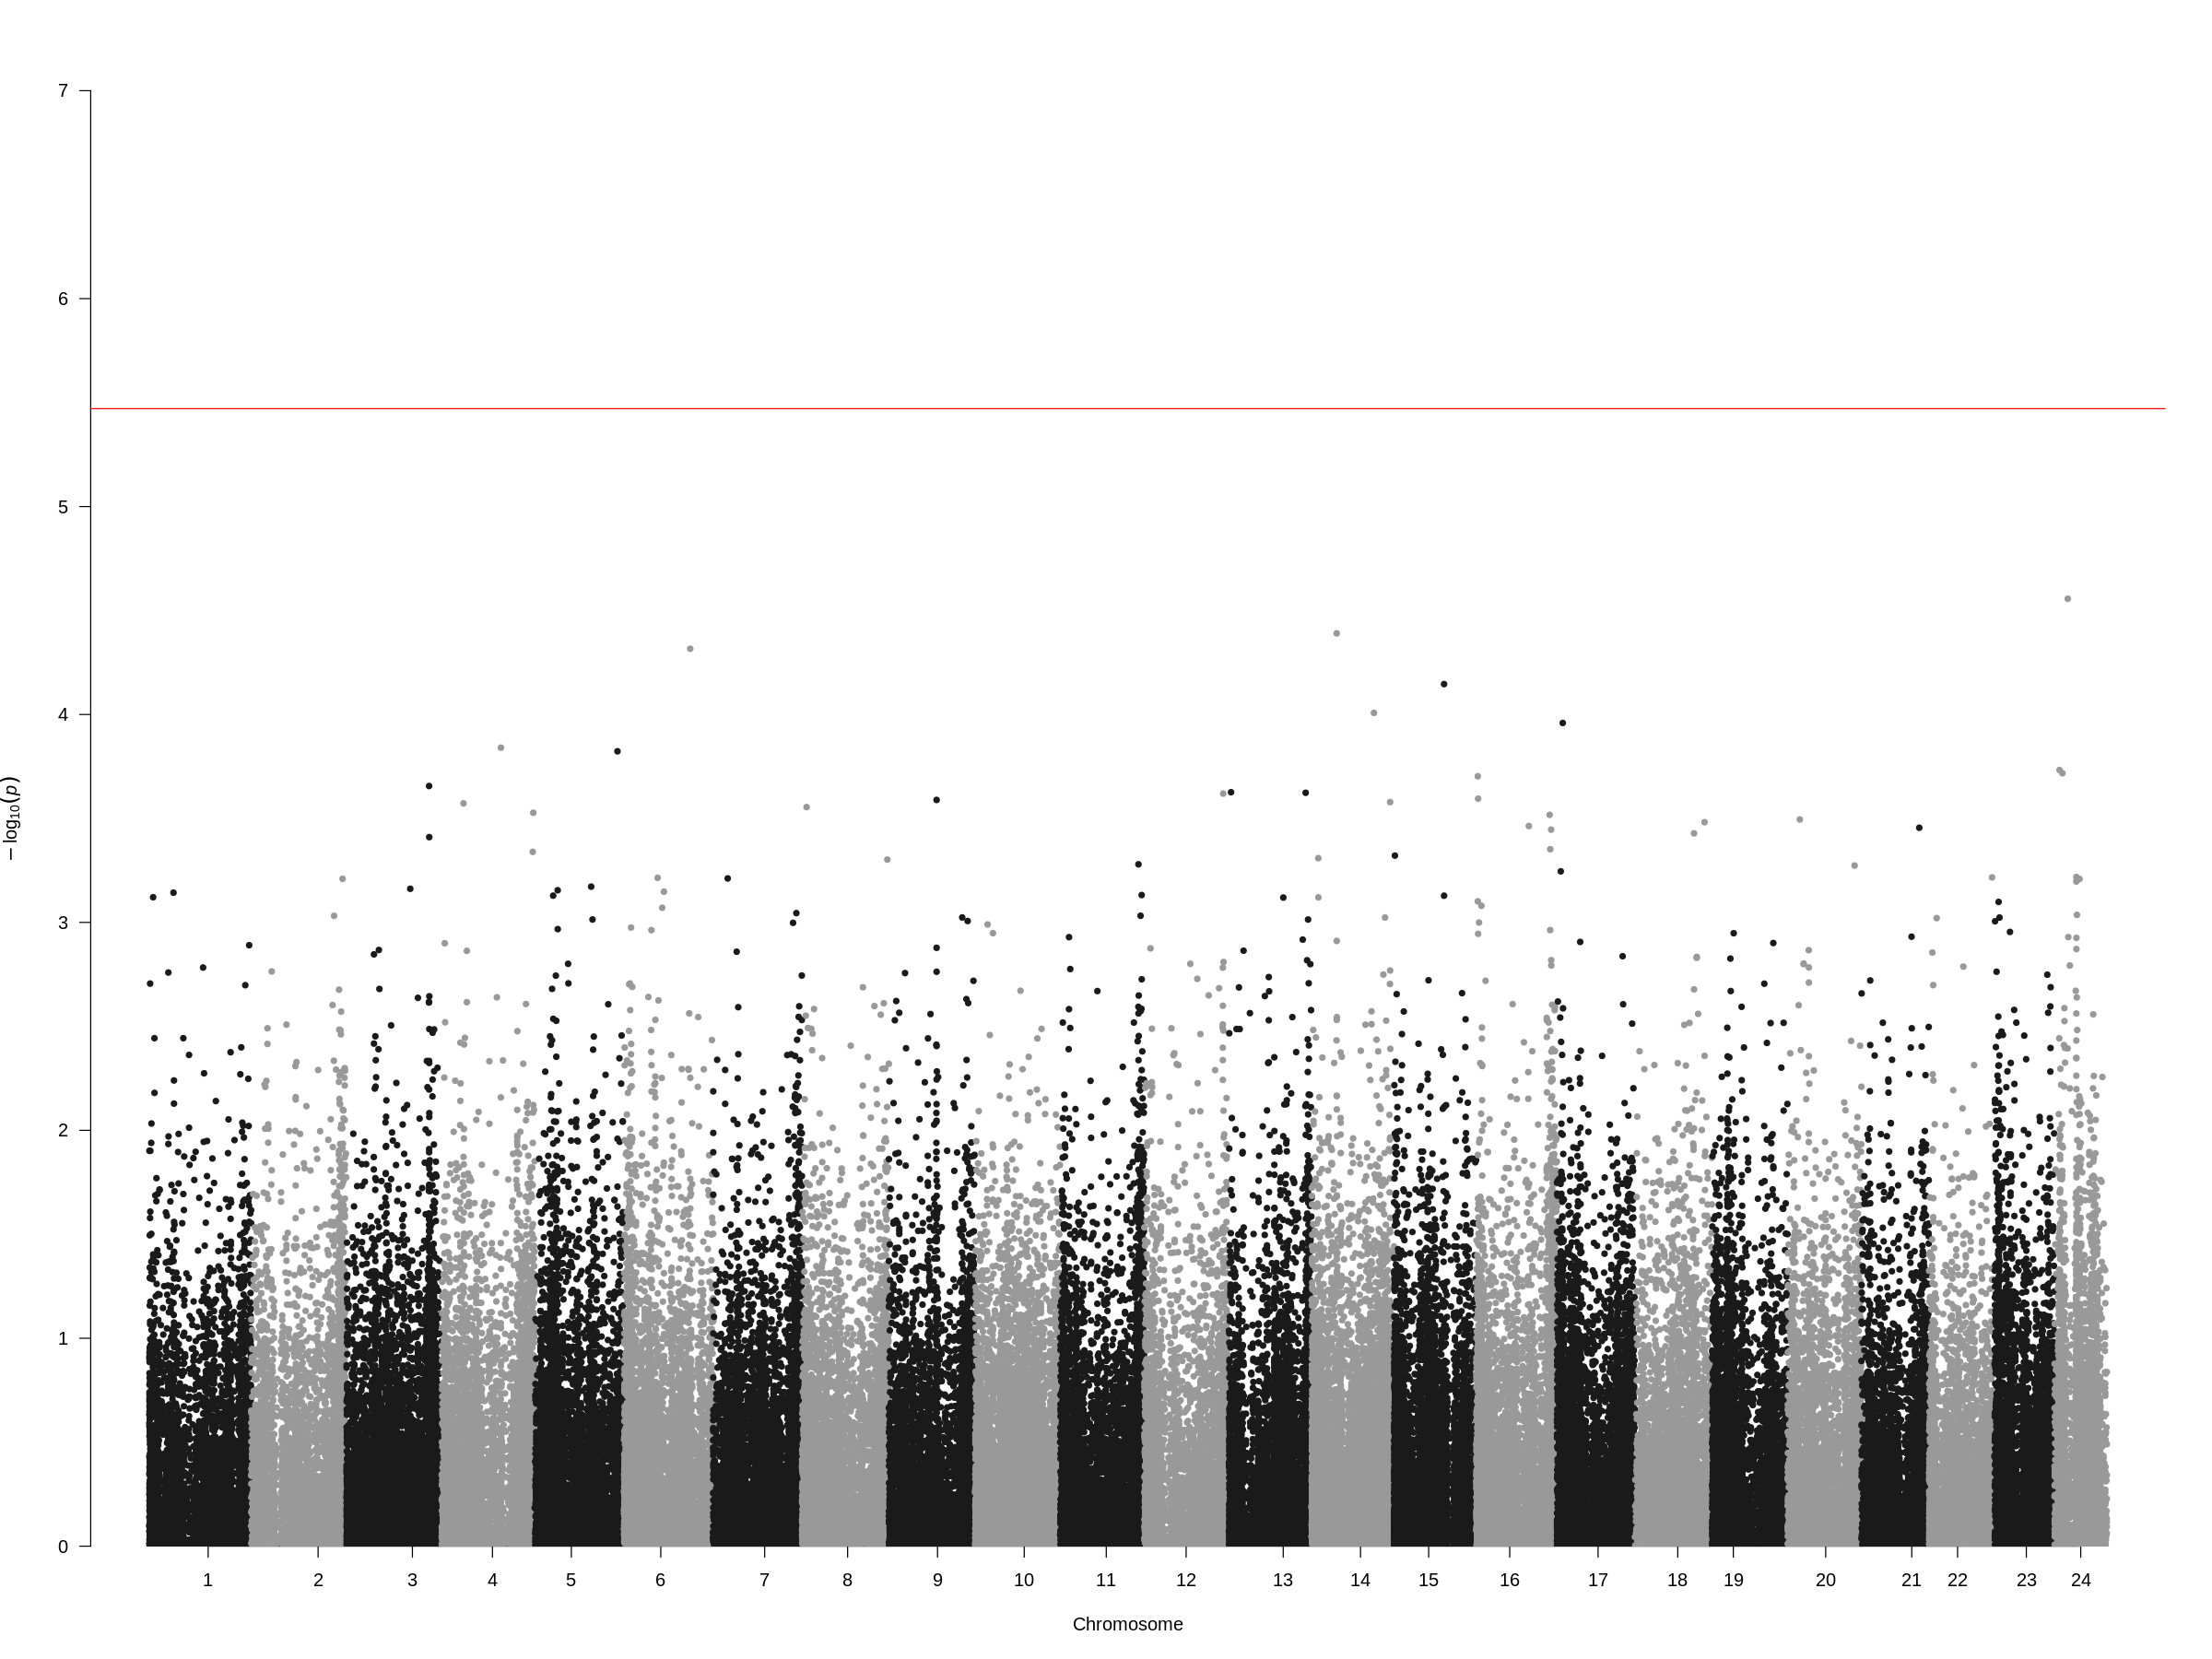

In [51]:
#gw_ucrit <- quantile(ucrit_null_lowest$null_min_pvalue, .025)[[1]]
#gw_ucrit_null <- dchisq(min(ucrit_null_top$LRT), df=1)
#png("/data/katrinac/APPC_sequencing/DNA/trimmed_reads/mapping/ensembl/genotypes/angsd/results/ucrit_manhattan_chrom_null_sig_minq_0.05.png")
qqman::manhattan(lrt_filt_ucrit, chr="Chromosome_man", bp="Position", p="pvalue", genomewideline = -log10(ucrit_gw_cutoff), ylim = c(0, 7), suggestiveline = F)#, highlight =lrt_filt_ucrit[locus %in% ucrit_perm_pvalues_int[pvalue < min_pvalue, locus], SNP])
#dev.off()
#gw_ucrit

In [42]:
str(lrt_filt_sl)
str(ucrit_snp_null)

Classes ‘data.table’ and 'data.frame':	105379 obs. of  12 variables:
 $ Chromosome    : chr  "1" "1" "1" "1" ...
 $ Position      : int  10004 32316 32326 32350 32897 33219 33269 33281 34051 34187 ...
 $ Major         : chr  "A" "T" "T" "A" ...
 $ Minor         : chr  "G" "G" "C" "G" ...
 $ Frequency     : num  0.11 0.34 0.206 0.299 0.199 ...
 $ N             : int  147 147 147 147 147 147 147 147 147 147 ...
 $ LRT           : num  0.0963 0.8433 0.8428 0.1254 1.0575 ...
 $ high_WT/HE/HO : chr  "42/14/0" "11/20/0" "20/11/0" "10/10/1" ...
 $ locus         : chr  "1:10004" "1:32316" "1:32326" "1:32350" ...
 $ pvalue        : num  0.756 0.358 0.359 0.723 0.304 ...
 $ Chromosome_man: num  1 1 1 1 1 1 1 1 1 1 ...
 $ SNP           : chr  "r1" "r2" "r3" "r4" ...
 - attr(*, ".internal.selfref")=<externalptr> 
Classes ‘data.table’ and 'data.frame':	89247 obs. of  7 variables:
 $ Chromosome: num  1 1 1 1 1 1 1 1 1 1 ...
 $ Position  : int  10004 32316 32326 32350 32897 33219 33269 33281 33475 34

In [44]:
#join with the GWAS results 
sl_perm_pvalues_int <- left_join(sl_snp_null, lrt_filt_sl, by=c(Chromosome="Chromosome_man", "Position"))
ucrit_perm_pvalues_int <- left_join(ucrit_snp_null, lrt_filt_ucrit, by=c(Chromosome="Chromosome_man", "Position"))


In [45]:
nrow(sl_perm_pvalues_int[pvalue < min_pvalue])
nrow(ucrit_perm_pvalues_int[pvalue < min_pvalue])

[1] 512

[1] 137

In [53]:
head(sl_perm_pvalues_int[pvalue < min_pvalue][order(pvalue)])
head(ucrit_perm_pvalues_int[pvalue < min_pvalue][order(pvalue)])

Chromosome,Position,min_pvalue,min_lrt,pval_0.01,pval_0.025,pval_0.05,Chromosome.y,Major,Minor,Frequency,N,LRT,high_WT/HE/HO,locus,pvalue,SNP
11,7825612,0.0005286381,8.0e-06,0.01800149,0.03179125,0.05641703,11,T,G,0.206307,147,21.31278,24/11/0,11:7825612,3.901212e-06,r50869
24,16962690,0.0015995173,5.0e-06,0.01340923,0.04080663,0.07955424,24,T,G,0.258409,147,20.29089,10/13/0,24:16962690,6.651661e-06,r104351
15,4387764,0.0048389039,2.8e-05,0.01728886,0.03122583,0.05219009,15,C,T,0.264829,147,18.68006,25/26/1,15:4387764,1.545908e-05,r68417
21,10182978,0.0028740559,3.0e-06,0.01115796,0.03154684,0.05387469,21,G,A,0.275357,147,17.30666,33/31/3,21:10182978,3.180698e-05,r93760
10,13433683,0.0107621608,1.0e-06,0.02398058,0.03305408,0.06720693,10,G,A,0.232027,147,16.86947,11/14/0,10:13433683,4.004047e-05,r44565
12,993809,0.0039601880,2.0e-06,0.02228757,0.03757691,0.07792556,12,C,T,0.236088,147,16.79673,10/11/0,12:993809,4.160487e-05,r54294


Chromosome,Position,min_pvalue,min_lrt,pval_0.01,pval_0.025,pval_0.05,Chromosome.y,Major,Minor,Frequency,N,LRT,high_WT/HE/HO,locus,pvalue,SNP
24,6021620,0.0038163988,2.1e-05,0.011458385,0.02324762,0.04942466,24,T,C,0.139610,159,17.56558,33/13/0,24:6021620,2.775673e-05,r129193
14,11396158,0.0016473497,5.0e-06,0.011356611,0.02491698,0.04005150,14,A,G,0.283847,159,16.83758,12/12/0,14:11396158,4.071885e-05,r78921
15,22742928,0.0005726666,1.9e-05,0.006983935,0.02032165,0.04411765,15,G,A,0.212140,159,15.77261,21/15/1,15:22742928,7.142914e-05,r88604
14,28287841,0.0010785913,2.0e-06,0.007543192,0.02994416,0.04565220,14,A,T,0.152335,159,15.17031,29/12/0,14:28287841,9.823603e-05,r81931
17,2650542,0.0019869418,3.0e-06,0.016016768,0.03588978,0.06843622,17,A,G,0.296772,159,14.95967,10/11/0,17:2650542,1.098339e-04,r96437
24,2283885,0.0058697019,2.3e-05,0.020793483,0.03354431,0.06400635,24,T,G,0.214089,159,13.97894,10/11/0,24:2283885,1.848702e-04,r128220


__given the power analysis results, do these candidates make sense? If not, no use in the enrichment__

In [ ]:
#hist(sl_null.05$Frequency, breaks = 40)
#hist(ucrit_null.05$Frequency, breaks = 40)
#hist(sl_candidates$Frequency, breaks = 40)
#hist(abs(ucrit_candidates$beta), breaks = 40)
#hist(abs(ucrit_candidates[pvalue >=gw_ucrit, beta]), breaks = 40)

__try using the permutations as the expected for the qq plot__

In [ ]:
#lrt_sl_null <- lrt_sl_null[LRT > 0][order(LRT)][,quantile:=1:nrow(lrt_sl_null[LRT > 0])/nrow(lrt_sl_null[LRT > 0])] #quantiles for observed lrt
#lrt_sl_null_filt <- lrt_sl_null[LRT >0][Chromosome %in% as.character(seq(1,24,1))][, pvalue:=pchisq(LRT, df=1, lower=F)]
png("/data/katrinac/APPC_sequencing/DNA/trimmed_reads/mapping/ensembl/genotypes/angsd/results/lrt_null_qq_sl.png")

qqplot(-log10(lrt_null_sl$pvalue), -log10(lrt_filt_sl$pvalue), xlab = "Expected -log10(p)", ylab="Observed -log10(p)")
abline(0, 1, col = "red")
dev.off()

In [ ]:
#lrt_ucrit_null <- lrt_ucrit_null[LRT > 0][order(LRT)][,quantile:=1:nrow(lrt_ucrit_null[LRT > 0])/nrow(lrt_ucrit_null[LRT > 0])] #quantiles for observed lrt
#lrt_ucrit_null_filt <- lrt_ucrit_null[LRT >0][Chromosome %in% as.character(seq(1,24,1))][, pvalue:=pchisq(LRT, df=1, lower=F)]
png("/data/katrinac/APPC_sequencing/DNA/trimmed_reads/mapping/ensembl/genotypes/angsd/results/lrt_null_qq_ucrit.png")
qqplot(-log10(lrt_null_ucrit$pvalue), -log10(lrt_filt_ucrit$pvalue), xlab = "Expected -log10(p)", ylab="Observed -log10(p)")
abline(0, 1, col = "red")
dev.off()

In [ ]:
head(lrt_filt_ucrit)

In [81]:
#only for manhattan plot
lrt_filt_ucrit[,Chromosome_man := gsub("chr", "", Chromosome)][, Chromosome_man:=as.numeric(Chromosome_man)]
lrt_filt_sl[,Chromosome_man := gsub("chr", "", Chromosome)][, Chromosome_man:=as.numeric(Chromosome_man)]


In [82]:
head(lrt_filt_sl)

Chromosome,Position,Major,Minor,Frequency,N,LRT,high_WT/HE/HO,locus,pvalue,SNP,Chromosome_man
chr1,10004,A,G,0.109734,147,0.096277,42/14/0,1:10004,0.7563440,r1,1
chr1,32316,T,G,0.339790,147,0.843309,11/20/0,1:32316,0.3584521,r2,1
chr1,32326,T,C,0.206107,147,0.842760,20/11/0,1:32326,0.3586086,r3,1
chr1,32350,A,G,0.299364,147,0.125366,10/10/1,1:32350,0.7232860,r4,1
chr1,32897,C,T,0.198828,147,1.057497,13/11/0,1:32897,0.3037868,r5,1
chr1,33219,A,G,0.245286,147,0.272930,13/12/0,1:33219,0.6013730,r6,1


In [127]:
#gw_sl <- quantile(sl_null_lowest$null_min_pvalue, .025)[[1]]
#gw_sl_null <- dchisq(min(sl_null_top$LRT), df=1)
#png("/data/katrinac/APPC_sequencing/DNA/trimmed_reads/mapping/ensembl/genotypes/angsd/results/sl_manhattan_chrom_null_sig_top0.0001.png")
qqman::manhattan(lrt_filt_sl, chr="Chromosome_man", bp="Position", p="pvalue", genomewideline = -log10(max(sl_null_top$null_pvalue)), suggestiveline = F, highlight =lrt_filt_sl[locus %in% sl_candidates[, locus], SNP])
#dev.off()
#gw_sl

png 
  2

In [136]:
#gw_ucrit <- quantile(ucrit_null_lowest$null_min_pvalue, .025)[[1]]
#gw_ucrit_null <- dchisq(min(ucrit_null_top$LRT), df=1)
png("/data/katrinac/APPC_sequencing/DNA/trimmed_reads/mapping/ensembl/genotypes/angsd/results/ucrit_manhattan_chrom_null_sig_top0.0001.png")
qqman::manhattan(lrt_filt_ucrit, chr="Chromosome_man", bp="Position", p="pvalue", genomewideline = -log10(max(ucrit_null_top$null_pvalue)), suggestiveline = F, highlight =lrt_filt_ucrit[locus %in% ucrit_candidates[, locus], SNP])
dev.off()
#gw_ucrit

png 
  2

In [141]:
fwrite(ucrit_candidates[,.(Chromosome=gsub("chr", "", Chromosome), start=Position-3000, end=Position+3000)], "/data/katrinac/APPC_sequencing/DNA/trimmed_reads/mapping/ensembl/genotypes/angsd/results/null_candidates_ucrit_loci3kbp_NullWay.bed", sep="\t", col.names = F)

In [ ]:
ucrit_cand[,.(Chromosome=gsub("chr", "", Chromosome), start=Position-3000, end=Position+3000)]

In [142]:
fwrite(sl_candidates[,.(Chromosome=gsub("chr", "", Chromosome), start=Position-3000, end=Position+3000)], "/data/katrinac/APPC_sequencing/DNA/trimmed_reads/mapping/ensembl/genotypes/angsd/results/null_candidates_sl_loci3kbp_NullWay.bed", sep="\t", col.names = F)

__write out the candidate positions to find closest feature in percula genome and blast against ocellaris for gene names__

In [143]:
candidates_sl_bedops <- sl_candidates[,.( Chromosome, start=Position-50, end=Position+50)]#, range=paste0(start, end, sep="-"))]
candidates_ucrit_bedops <- ucrit_candidates[,.( Chromosome, start=Position-50, end=Position+50)]#, range=paste0(start, end, sep="-"))]
fwrite(candidates_sl_bedops[,.(Chromosome, start, end)], "/data/katrinac/APPC_sequencing/DNA/trimmed_reads/mapping/ensembl/genotypes/angsd/results/candidates_sl_loci50bpNullWay.bed", sep="\t", col.names = F)
fwrite(candidates_ucrit_bedops[,.(Chromosome, start, end)], "/data/katrinac/APPC_sequencing/DNA/trimmed_reads/mapping/ensembl/genotypes/angsd/results/candidates_ucrit_loci50bpNullWay.bed", sep="\t", col.names = F)

__read in and sort the blast results__

__read in the results for the nearest gene and join with blast results__

In [148]:
sl_oce <- fread("/data/katrinac/APPC_sequencing/DNA/trimmed_reads/mapping/ensembl/genotypes/angsd/results/sl_ATZPJ1PB013-Alignment-HitTable3kbp_null.csv")
sl_oce_best <- unique(sl_oce[, .(seqid=V1, accession=V2, per_id=V3, evalue=V11)][, .SD[which.min(evalue)], by=seqid][ ,.(seqid, accession, per_id, evalue)], by="seqid")
(sl_oce_best)
fwrite(sl_oce_best, "/data/katrinac/APPC_sequencing/DNA/trimmed_reads/mapping/ensembl/genotypes/angsd/results/sl_oce_best_3kbp_null.csv")

gff_names <- c("seqid", "start","locus", "feature_start", "feature_end", "feature_id", "score", "strand", "unkn", "feature_type", "phase", "attributes")
sl_nearest <- fread("/data/katrinac/APPC_sequencing/DNA/trimmed_reads/mapping/ensembl/genotypes/angsd/results/sl_results_candidates_50bp_percula_nearestNullWay.bed", sep="\t", fill = T)
setnames(sl_nearest, gff_names)

#split the attributs column to get the gene name and the go terms
sl_split <- sl_nearest[, c('gene_id', 'protein_family', 'go_term_dist'):= tstrsplit(attributes, ";")][, c('go_term', 'dist_bp'):= tstrsplit(go_term_dist, "|", fixed=T),by="gene_id"]#[dist_bp ==0]
sl_split[, gene_id:=gsub("ID=", "", gene_id)][, go_term:=gsub("Ontology_term=", "", go_term)][, go_term:=gsub(",", " ", go_term)]
sl_split <- sl_split[, .(seqid, start, locus, feature_start, feature_end, gene_id, go_term, dist_bp)]

sl_oce_best[, c("Chromosome", "start_end"):= tstrsplit(seqid, ":")][,c("start", "end"):= tstrsplit(start_end, "-")][, start:=as.numeric(start)]
sl_split <- sl_split[, Chromosome:=gsub("chr", "", seqid)][, start:=as.numeric(start)]

sl_blast_and_nearest <- sl_split[sl_oce_best, roll = "nearest", on = c("Chromosome", "start")][is.na(dist_bp), dist_bp:=0][, .(Chromosome=as.numeric(Chromosome), feature_start=start, feature_id=gene_id, go_term, dist_bp, A.ocellaris_acession=accession, evalue, per_id)]  

seqid,accession,per_id,evalue
2:5429895-5435894,XM_023283859.2,98.559,0.00e+00
10:23408451-23414450,XM_023298591.2,83.424,6.05e-108
16:29991949-29997948,XM_023290920.2,77.202,1.43e-33
17:32870422-32876421,XM_023269367.2,83.529,4.99e-14
21:10179979-10185978,XM_023290920.2,78.947,1.00e-03
21:10179993-10185992,XM_023290920.2,78.947,1.00e-03
23:25796411-25802410,XM_023273293.2,67.596,2.27e-18
24:2561033-2567032,XM_035956426.1,84.553,1.10e-28


Warning message in `[.data.table`(sl_split[sl_oce_best, roll = "nearest", on = c("Chromosome", :
“Coerced double RHS to character to match the type of the target column (column 8 named 'dist_bp'). If the target column's type character is correct, it's best for efficiency to avoid the coercion and create the RHS as type character. To achieve that consider R's type postfix: typeof(0L) vs typeof(0), and typeof(NA) vs typeof(NA_integer_) vs typeof(NA_real_). You can wrap the RHS with as.character() to avoid this warning, but that will still perform the coercion. If the target column's type is not correct, it's best to revisit where the DT was created and fix the column type there; e.g., by using colClasses= in fread(). Otherwise, you can change the column type now by plonking a new column (of the desired type) over the top of it; e.g. DT[, `dist_bp`:=as.double(`dist_bp`)]. If the RHS of := has nrow(DT) elements then the assignment is called a column plonk and is the way to change a column'

In [149]:
sl_blast_and_nearest

Chromosome,feature_start,feature_id,go_term,dist_bp,A.ocellaris_acession,evalue,per_id
2,5429895,APERC1_00005239,GO:0005164 GO:0006955 GO:0016020,0,XM_023283859.2,0.00e+00,98.559
10,23408451,APERC1_00008302,GO:0003676,0,XM_023298591.2,6.05e-108,83.424
16,29991949,APERC1_00016898,GO:0005515 GO:0005634 GO:0008270 GO:0018024 GO:0034968,-7512,XM_023290920.2,1.43e-33,77.202
17,32870422,APERC1_00022076|-7061,NA,0,XM_023269367.2,4.99e-14,83.529
21,10179979,APERC1_00025071,NA,0,XM_023290920.2,1.00e-03,78.947
21,10179993,APERC1_00025071,NA,0,XM_023290920.2,1.00e-03,78.947
23,25796411,APERC1_00022962,NA,0,XM_023273293.2,2.27e-18,67.596
24,2561033,APERC1_00025668,GO:0003700 GO:0005634 GO:0006355 GO:0043565,0,XM_035956426.1,1.10e-28,84.553


In [144]:
#for ucrit
ucrit_oce <- fread("/data/katrinac/APPC_sequencing/DNA/trimmed_reads/mapping/ensembl/genotypes/angsd/results/ucrit_ATZK8VZP013-Alignment-HitTable3kbp_null.csv")
ucrit_oce_best <- unique(ucrit_oce[, .(seqid=V1, accession=V2, per_id=V3, evalue=V11)][, .SD[which.min(evalue)], by=seqid][ ,.(seqid, accession, per_id, evalue)], by="seqid")
ucrit_oce_best

gff_names <- c("seqid", "start","locus", "feature_start", "feature_end", "feature_id", "score", "strand", "unkn", "feature_type", "phase", "attributes")
ucrit_nearest <- fread("/data/katrinac/APPC_sequencing/DNA/trimmed_reads/mapping/ensembl/genotypes/angsd/results/ucrit_results_candidates_50bp_percula_nearestNullWay.bed", sep="\t", fill = T)
setnames(ucrit_nearest, gff_names)

#split the attributs column to get the gene name and the go terms
ucrit_split <- ucrit_nearest[, c('gene_id', 'protein_family', 'go_term_dist'):= tstrsplit(attributes, ";")][, c('go_term', 'dist_bp'):= tstrsplit(go_term_dist, "|", fixed=T),by="gene_id"]#[dist_bp ==0]
ucrit_split[, gene_id:=gsub("ID=", "", gene_id)][, go_term:=gsub("Ontology_term=", "", go_term)][, go_term:=gsub(",", " ", go_term)]
ucrit_split <- ucrit_split[, .(seqid, start, locus, feature_start, feature_end, gene_id, go_term, dist_bp)]

ucrit_oce_best[, c("Chromosome", "start_end"):= tstrsplit(seqid, ":")][,c("start", "end"):= tstrsplit(start_end, "-")][, start:=as.numeric(start)]
ucrit_split <- ucrit_split[, Chromosome:=gsub("chr", "", seqid)][, start:=as.numeric(start)]

ucrit_blast_and_nearest <- ucrit_split[ucrit_oce_best, roll = "nearest", on = c("Chromosome", "start")][is.na(dist_bp), dist_bp:=0][, .(Chromosome=as.numeric(Chromosome), feature_start=start, feature_id=gene_id, go_term, dist_bp, A.ocellaris_acession=accession, evalue, per_id)]  

#fwrite(ucrit_blast_and_nearest, "/data/katrinac/APPC_sequencing/DNA/trimmed_reads/mapping/ensembl/genotypes/angsd/results/ucrit_oce_best_3kbpNull.csv")


seqid,accession,per_id,evalue
14:28284842-28290841,XR_004846148.1,99.086,0.00e+00
24:3609439-3615438,XM_035948710.1,68.391,8.45e-05


In [151]:
fwrite(ucrit_blast_and_nearest, "/data/katrinac/APPC_sequencing/DNA/trimmed_reads/mapping/ensembl/genotypes/angsd/results/ucrit_oce_best_3kbpNull.csv")


In [150]:
fwrite(sl_blast_and_nearest, "/data/katrinac/APPC_sequencing/DNA/trimmed_reads/mapping/ensembl/genotypes/angsd/results/sl_oce_best_3kbpNull.csv")


## Look for enriched go terms with topgo

In [ ]:
all_sl_bedops <- lrt_filt_sl[,.(locus, Chromosome, start=Position-50, end=Position+50)][Chromosome %like% "chr"]#[,Chromosome := paste0("chr", Chromosome, sep="")]#, range=paste0(start, end, sep="-"))]
all_ucrit_bedops <- lrt_filt_ucrit[,.(locus, Chromosome, start=Position-50, end=Position+50)][Chromosome %like% "chr"]#[,Chromosome := paste0("chr", Chromosome, sep="")]#, range=paste0(start, end, sep="-"))]
#fwrite(all_sl_bedops[,.(Chromosome, start, end)], "/data/katrinac/APPC_sequencing/DNA/trimmed_reads/mapping/ensembl/genotypes/angsd/results/all_sl_loci50bp.bed", sep="\t", col.names = F)
#fwrite(all_ucrit_bedops[,.(Chromosome, start, end)], "/data/katrinac/APPC_sequencing/DNA/trimmed_reads/mapping/ensembl/genotypes/angsd/results/all_ucrit_loci50bp.bed", sep="\t", col.names = F)#

In [ ]:
head(sl_nearest)

In [ ]:
#load in the gff file from closest-feature
gff_names <- c("seqid", "start","locus", "feature_start", "feature_end", "feature_id", "score", "strand", "unkn", "feature_type", "phase", "attributes")
sl_nearest <- fread("/data/katrinac/APPC_sequencing/DNA/trimmed_reads/mapping/ensembl/genotypes/angsd/results/sorted_all_sl_50bp_percula_nearest.bed", sep="\t", fill = T)
setnames(sl_nearest, gff_names)

#split the attributs column to get the gene name and the go terms
split <- sl_nearest[, c('gene_id', 'protein_family', 'go_term_dist'):= tstrsplit(attributes, ";")][, c('go_term', 'dist_bp'):= tstrsplit(go_term_dist, "|", fixed=T),by="gene_id"][dist_bp ==0]

go_sl <- split[!is.na(gene_id), .(gene_id=gsub("ID=", "", gene_id), go_term=gsub("Ontology_term=", "", go_term))][, go_term:=gsub(",", " ", go_term)][!is.na(go_term)]
go_sl <- unique(go_sl, by="gene_id")
go_terms <- by(go_sl, go_sl$gene_id,function(x) setNames(x$go_term,x$name))

go_sl <- split[!is.na(gene_id), .(gene_id=gsub("ID=", "", gene_id), go_term=gsub("Ontology_term=", "", go_term))][, go_term:=gsub(",", " ", go_term)][!is.na(go_term)]
go_sl_vec <- go_sl[, setNames(go_term, gene_id)]

               #sl_cand[, locus := paste(Chromosome, Position, sep=":")][,locus := gsub("chr", "", locus)]
           
          
sl_locus_lrt <- left_join(all_sl_bedops, lrt_filt_sl)[, sig:= pvalue][, .(Chromosome, start, end, sig)]#[, sig:=ifelse(locus %in% sl_candidates$locus, 1, 0)]
genes_score <- left_join(sl_locus_lrt, split[, .(seqid, start, feature_id)], by="start")[, .(feature_id, sig)][!is.na(feature_id)]
genes_score <- unique(genes_score[order(-sig)], by="feature_id")
genes_score_vec <- genes_score[, setNames(sig, feature_id)]
               
#sig <- max(candidates_sl$pvalue)
#sig <- max(lrt_filt_sl_sig$pvalue)
GOdata <- new("topGOdata", description="go analysis of closest genes for a percula phenotype of sl", ontology="BP", allGenes=genes_score_vec, geneSel = function(sig) {sig < 1},  annotationFun=annFUN.gene2GO, gene2GO=go_sl_vec, nodeSize=50)  

test.stat <- new("classicScore", testStatistic = GOKSTest, name = "KS test")
resultClassic <- getSigGroups(GOdata, test.stat)
##pValue.classic <- score(resultFisher)

#test.stat <- new("weightCount", testStatistic = GOFisherTest, name = "Fisher test", sigRatio = "ratio")
#resultWeight <- getSigGroups(GOdata, test.stat)

test.stat <- new("elimScore", testStatistic = GOKSTest, name = "KS test")
resultElim <- getSigGroups(GOdata, test.stat)

allRes <- GenTable(GOdata, classic = resultClassic, elim= resultElim)
               allRes

In [ ]:
GOdata <- new("topGOdata", description="go analysis of closest genes for a percula phenotype of sl", ontology="BP", allGenes=genes_score_vec, geneSel = function(sig) {sig < gw_sl},  annotationFun=annFUN.gene2GO, gene2GO=go_sl_vec, nodeSize=5)  

resultClassic <- runTest(GOdata, algorithm="classic", statistic="ks")
##pValue.classic <- score(resultFisher)

#test.stat <- new("weightCount", testStatistic = GOFisherTest, name = "Fisher test", sigRatio = "ratio")
#resultWeight <- getSigGroups(GOdata, test.stat)

resultElim <- runTest(GOdata, algorithm="elim", statistic="ks")

allRes <- GenTable(GOdata, classic = resultClassic, elim= resultElim, orderBy="classic")
setDT(allRes)
               allRes#[Significant>0]

In [ ]:
           
sl_locus_lrt <- left_join(all_sl_bedops, lrt_filt_sl)[, sig:=ifelse(locus %in% sl_cand$locus, 1, 0)][, .(Chromosome, start, end, sig)]
genes_score <- left_join(sl_locus_lrt, split[, .(seqid, start, feature_id)], by="start")[, .(feature_id, sig)][!is.na(feature_id)]
#genes_score <- unique(genes_score[order(-sig)], by="feature_id")
genes_score_vec <- genes_score[, setNames(sig, feature_id)]

In [ ]:
nrow(ucrit_candidates)

## perform enrichment test on gene score distribution with topGo https://montilab.github.io/BS831/articles/docs/KS_Enrichment.html

In [ ]:
#load in the gff file from closest-feature
gff_names <- c("seqid", "start","locus", "feature_start", "feature_end", "feature_id", "score", "strand", "unkn", "feature_type", "phase", "attributes")
ucrit_nearest <- fread("/data/katrinac/APPC_sequencing/DNA/trimmed_reads/mapping/ensembl/genotypes/angsd/results/sorted_all_ucrit_50bp_percula_nearest.bed", sep="\t", fill = T)
setnames(ucrit_nearest, gff_names)

#split the attributs column to get the gene name and the go terms
split <- ucrit_nearest[, c('gene_id', 'protein_family', 'go_term_dist'):= tstrsplit(attributes, ";")][, c('go_term', 'dist_bp'):= tstrsplit(go_term_dist, "|", fixed=T),by="gene_id"][dist_bp <=5000]

go_ucrit <- split[!is.na(gene_id), .(gene_id=gsub("ID=", "", gene_id), go_term=gsub("Ontology_term=", "", go_term))][, go_term:=gsub(",", " ", go_term)][!is.na(go_term)]
go_ucrit <- unique(go_ucrit, by="gene_id")
go_terms <- by(go_ucrit, go_ucrit$gene_id,function(x) setNames(x$go_term,x$name))

go_ucrit <- split[!is.na(gene_id), .(gene_id=gsub("ID=", "", gene_id), go_term=gsub("Ontology_term=", "", go_term))][, go_term:=gsub(",", " ", go_term)][!is.na(go_term)]
go_ucrit_vec <- go_ucrit[, setNames(go_term, gene_id)]

               #ucrit_cand[, locus := paste(Chromosome, Position, sep=":")][,locus := gsub("chr", "", locus)]
           
ucrit_locus_lrt <- left_join(all_ucrit_bedops, lrt_filt_ucrit)[, sig:=ifelse(locus %in% ucrit_candidates_power.9$locus, 1, 0)][, .(Chromosome, start, end, sig)]#
genes_score <- left_join(ucrit_locus_lrt, split[, .(seqid, start, feature_id)], by="start")[, .(feature_id, sig)][!is.na(feature_id)]
#genes_score <- unique(genes_score[order(-sig)], by="feature_id")
genes_score_vec <- genes_score[, setNames(sig, feature_id)]
               
#sig <- max(candidates_ucrit$pvalue)
#sig <- max(lrt_filt_ucrit_sig$pvalue)
GOdata <- new("topGOdata", description="go analysis of closest genes for a percula phenotype of ucrit", ontology="BP", allGenes=genes_score_vec, geneSel = function(sig) {sig <= gw_ucrit}, annotationFun=annFUN.gene2GO, gene2GO=go_ucrit_vec, nodeSize=10)  

resultKS <- runTest(GOdata, algorithm="classic", statistic="ks")

resultCount_elim <- runTest(GOdata, algorithm="elim", statistic="fisher")
               

#allRes <- GenTable(GOdata, classic = pValue.classic, elim= resultElim, weight=resultWeight, orderBy="elim",ranksOf = "classic", topNodes = 40)
#allRes

In [ ]:
allRes <- GenTable(GOdata, classic_KS=resultKS, orderBy="classic_KS", topNodes = 40) #,ranksOf = "elim_KS",
allRes
setDT(allRes)
#allRes[Significant >0]

In [ ]:
gw_ucrit
nrow(ucrit_locus_lrt[sig <= gw_ucrit])

In [ ]:
genes_score <- left_join(ucrit_locus_lrt, split[, .(seqid, start, feature_id, go_term)], by="start")[, go_term:=gsub("Ontology_term=", "", go_term)][, Position := start+50]#[, .(feature_id, sig)][!is.na(feature_id)]


In [ ]:
head(genes_score[sig==1])

In [ ]:
head(genes_score)

__Pull out the significant features, write out the positions to blast zebra with seqk__

In [ ]:
#test.stat <- new("classicScore", testStatistic = GOKSTest, name = "KS tests")
#resultKS <- getSigGroups(GOdata, test.stat)

test.stat <- new("classicCount", testStatistic = GOFisherTest, name = "Fisher test")
resultFisher <- getSigGroups(GOdata, test.stat)
#pValue.classic <- score(resultFisher)

#test.stat <- new("weightCount", testStatistic = GOFisherTest, name = "Fisher test", sigRatio = "ratio")
#resultWeight <- getSigGroups(GOdata, test.stat)

test.stat <- new("elimScore", testStatistic = GOKSTest, name = "Fisher test", cutOff = 0.01)
resultElim <- getSigGroups(GOdata, test.stat)

allRes <- GenTable(GOdata, classic = resultFisher, elim= resultElim)

In [ ]:
(allRes)

In [ ]:
allRes <- GenTable(GOdata,  elim = resultKS.elim, orderBy = "elim")

In [ ]:
allRes

In [ ]:
fwrite(allRes, "/data/katrinac/APPC_sequencing/DNA/trimmed_reads/mapping/ensembl/genotypes/angsd/results/GO_table_null_cutoff_sl.csv")

In [ ]:
#fwrite(allRes, "/data/katrinac/APPC_sequencing/DNA/trimmed_reads/mapping/ensembl/genotypes/angsd/results/GO_table_BH_cutoff_sl.csv")

__make a table of genes and pvalues for results__

In [ ]:
sl_gff_join <- split[, .(Chromosome=seqid, Position=start+50, gene_id=gsub("ID=", "", gene_id), go_term=gsub("Ontology_term=", "", go_term), dist_bp)]
sl_gene_join <- candidate_sl_bh[,.(Chromosome =paste0("chr", Chromosome, ""), Position, Frequency, pvalue, locus)]
sl_gene_ids <- (left_join(sl_gene_join, sl_gff_join))[!is.na(dist_bp)][, chrom_sig_0.05 := ifelse(locus %in% candidate_sl_chrom_bh$locus, "yes", "no")]
#fwrite(sl_gene_ids, "/data/katrinac/APPC_sequencing/DNA/trimmed_reads/mapping/ensembl/genotypes/angsd/results/genes_table_BH_cutoff_sl.csv")

__for ucrit__

In [ ]:
#load in the gff file from closest-feature
gff_names <- c("seqid", "start","locus", "feature_start", "feature_end", "feature_id", "score", "strand", "unkn", "feature_type", "phase", "attributes")
ucrit_nearest <- fread("/data/katrinac/APPC_sequencing/DNA/trimmed_reads/mapping/ensembl/genotypes/angsd/results/sorted_all_ucrit_50bp_percula_nearest.bed", sep="\t", fill = T)
setnames(ucrit_nearest, gff_names)

split <- ucrit_nearest[, c('gene_id', 'protein_family', 'go_term_dist'):= tstrsplit(attributes, ";")][, c('go_term', 'dist_bp'):= tstrsplit(go_term_dist, "|", fixed=T),by="gene_id"]

ucrit_locus_lrt <- left_join(all_ucrit_bedops, lrt_filt_ucrit[,Chromosome := paste0("chr", Chromosome, "")][pvalue>1, pvalue:=1])[, .(Chromosome, start, end, pvalue)]
genes_score <- left_join(ucrit_locus_lrt, split[, .(seqid, start, feature_id)], by="start")[, .(feature_id, pvalue)][!is.na(feature_id)]
genes_score <- unique(genes_score, by="feature_id")
genes_score_vec <- genes_score[, setNames(pvalue, feature_id)]

go_ucrit <- split[!is.na(gene_id), .(gene_id=gsub("ID=", "", gene_id), go_term=gsub("Ontology_term=", "", go_term))][, go_term:=gsub(",", " ", go_term)][!is.na(go_term)]
go_ucrit_vec <- go_ucrit[, setNames(go_term, gene_id)]

sig <- max(candidates_ucrit$pvalue)
#sig <- max(lrt_filt_ucrit_sig$pvalue)
GOdata <- new("topGOdata", description="go analysis of closest genes for a percula phenotype of ucrit", ontology="BP", allGenes=genes_score_vec, geneSel = function(foo) {foo < sig}, annotationFun=annFUN.gene2GO, gene2GO=go_ucrit_vec)

test.stat <- new("classicScore", testStatistic = GOKSTest, name = "KS tests")
resultKS <- getSigGroups(GOdata, test.stat)

test.stat <- new("classicCount", testStatistic = GOFisherTest, name = "Fisher test")
resultFisher <- getSigGroups(GOdata, test.stat)
pValue.classic <- score(resultFisher)

test.stat <- new("weightCount", testStatistic = GOFisherTest, name = "Fisher test", sigRatio = "ratio")
resultWeight <- getSigGroups(GOdata, test.stat)

test.stat <- new("elimScore", testStatistic = GOKSTest, name = "Fisher test", cutOff = 0.01)
resultElim <- getSigGroups(GOdata, test.stat)

allRes <- GenTable(GOdata, classic = resultFisher, elim= resultElim, orderBy = "classic", ranksOf = "classic", topNodes = 40)

In [ ]:
ucrit_nearest[seqid=="chr24" & start==6021620-50]

In [ ]:
head(ucrit_nearest)

In [ ]:
candidates_ucrit

In [ ]:
pValue.classic <- score(resultFisher)
allRes <- GenTable(GOdata, raw.p.value = resultFisher, KS = resultKS, weight = resultWeight, orderBy = "raw.p.value", ranksOf = "raw.p.value")

In [ ]:
raw.p.value = resultFisher,

In [ ]:
allRes

In [ ]:
fwrite(allRes, "/data/katrinac/APPC_sequencing/DNA/trimmed_reads/mapping/ensembl/genotypes/angsd/results/GO_table_null_cutoff_ucrit.csv")

__make a table of genes and pvalues for results__

In [ ]:
ucrit_gff_join <- split[, .(Chromosome=seqid, Position=start+50, gene_id=gsub("ID=", "", gene_id), go_term=gsub("Ontology_term=", "", go_term), dist_bp)]
ucrit_gene_join <- candidates_ucrit[,.(Chromosome =paste0("chr", Chromosome, ""), Position, Frequency, pvalue, locus)]
ucrit_gene_ids <- (left_join(ucrit_gene_join, ucrit_gff_join))[!is.na(dist_bp)][, chrom_sig_0.05 := ifelse(locus %in% candidate_ucrit_chrom_bh$locus, "yes", "no")][order(pvalue)]
fwrite(ucrit_gene_ids, "/data/katrinac/APPC_sequencing/DNA/trimmed_reads/mapping/ensembl/genotypes/angsd/results/genes_table_BH_cutoff_ucrit.csv")

In [ ]:
candidates_ucrit[,prop_var_exp :=  (2*(beta^2)*Frequency*(1-Frequency))/(2*(beta^2)*Frequency*(1-Frequency)+((SE*(beta))^2)*2*N*Frequency*(1-Frequency)), by=locus]

In [ ]:
head(candidates_ucrit[order(-prop_var_exp)])

__Plot the ucrit distributions for each genotype of the significant locus__

In [ ]:
genos <- fread("/data/katrinac/APPC_sequencing/Genome/candidates/ucrit_cand_genos.gprobs")
long_genos <- melt(genos, id.vars = c("V1", "V2", "V3"))
samples <- pca_phenos[, .(sample)][rep(seq_len(nrow(pca_phenos)), 3), ][order(sample)]
samples$genotype <- rep(seq(1, 3, 1), 159)
setnames(long_genos, c("marker", "allele1", "allele2", "sample", "gprob"))
long_genos$sample <- samples$sample
long_genos$geno <- samples$genotype

In [ ]:
#restrict to grpob > .9
nrow(long_genos[gprob>=0.9])

In [ ]:
#join with ucrit data
ucrit_genos <- left_join(long_genos[gprob>=0.9], pca_phenos[, .(sample, ucrit)])
#from angsd the major allele codes as 0=A, 1=C, 2=G, 3=T 
#the minor allele codes as 0=A, 1=C, 2=G, 3=T 
#row 1- grpob for major/major, row2 major/minor, row3 minor/minor
#for this locus major is T and minor is C.
ucrit_genos[, genotype:=ifelse(geno==1, "TT", ifelse(geno==2, "TC", "CC"))]

In [ ]:
#join with ucrit data
head(ucrit_genos)

In [ ]:
ucrit_plot <- ggplot()+
geom_boxplot(data=ucrit_genos, aes(x=genotype, y=ucrit))+
 ylab("Ucrit") +
    xlab("Genotype")+
    theme(strip.text.x = element_text(size = 14),
    legend.position = "bottom",
    legend.key=element_blank(),
    panel.grid.major = element_blank(),
    panel.grid.minor = element_blank(), 
    panel.background = element_blank(), #,
    axis.line = element_line(colour = "black"),axis.text.x =  element_text(size=14, color="black"),#15 for publication, 20 for presentation #element_text(size=15, color="black", family="Helvetica"),
    axis.title.y =  element_text(size=18, color="black"),
    axis.title.x =  element_text(size=18, color="black"),#15 for publication, 20 for presentation #element_text(size=15, color="black", family="Helvetica"),
    axis.text.y =  element_text(size=18, color="black"))


In [ ]:
ucrit_plot
ggsave(ucrit_plot, file="/data/katrinac/APPC_sequencing/DNA/trimmed_reads/mapping/ensembl/genotypes/angsd/results/ucrit_genotypes.pdf")

In [ ]:
tail(genos)

In [ ]:
Proportion of variance in phenotype explained by a given SNP (PVE) = [2*(beta^2)*MAF*(1-MAF)]/[2*(beta^2)*MAF(1-MAF)+((se(beta))^2)*2*N*MAF*(1-MAF)]
where:
N - sample size
se(beta) - standard error of effect size for the genetic variant of interest
beta - effect size for the genetic variant of interest
MAF - minor allele frequency for the genetic variant of interest
it is described in:
Shim, H., Chasman, D.I., Smith, J.D., Mora, S., Ridker, P.M., Nickerson, D.A., Krauss, R.M., and Stephens, M. (2015). A multivariate genome-wide association analysis of 10 LDL subfractions, and their response to statin treatment, in 1868 Caucasians. PLoS One 10, e0120758.
Supplementary Information: S1: Computing proportion of variance in phenotype explained by a given SNP (PVE).